<a href="https://colab.research.google.com/github/b21renu/DeepFakes/blob/main/RPFinal_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# Code: CNN-LSTM Model Fine-Tuning and Testing
DATASET LINK : https://www.kaggle.com/datasets/hungle3401/faceforensics/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow opencv-python-headless numpy

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam

In [ ]:
# Data generator for video sequences
def video_data_generator(folder_path, label, batch_size=4, sequence_length=20):
    while True:
        videos = os.listdir(folder_path)
        np.random.shuffle(videos)
        x, y = [], []

        for video_name in videos:
            video_path = os.path.join(folder_path, video_name)
            video = cv2.VideoCapture(video_path)
            frames = []

            # Read and preprocess frames
            while video.isOpened() and len(frames) < sequence_length:
                ret, frame = video.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (64, 64))
                frame = img_to_array(frame) / 255.0  # Normalize
                frames.append(frame)

            video.release()

            # Only use complete sequences
            if len(frames) == sequence_length:
                x.append(frames)
                y.append(label)

            # Yield batch
            if len(x) == batch_size:
                yield np.array(x), np.array(y)
                x, y = [], []

In [ ]:
real_videos_path = '/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real'
fake_videos_path = '/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/fake'

# Generators for training
real_data_generator = video_data_generator(real_videos_path, label=0, batch_size=4, sequence_length=20)
fake_data_generator = video_data_generator(fake_videos_path, label=1, batch_size=4, sequence_length=20)

In [ ]:
# CNN-LSTM model setup for fine-tuning
def build_cnn_lstm_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 64, 64, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def combined_generator(real_gen, fake_gen):
    while True:
        real_data = next(real_gen)
        fake_data = next(fake_gen)
        x_combined = np.concatenate((real_data[0], fake_data[0]), axis=0)
        y_combined = np.concatenate((real_data[1], fake_data[1]), axis=0)
        indices = np.arange(len(y_combined))
        np.random.shuffle(indices)
        yield x_combined[indices], y_combined[indices]

train_generator = combined_generator(real_data_generator, fake_data_generator)

In [ ]:
steps_per_epoch = 100  # Adjust this based on your dataset size
epochs = 10  # Set this to the number of epochs you want

model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 546s 5s/step - accuracy: 0.5215 - loss: 1.2232
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 538s 5s/step - accuracy: 0.7179 - loss: 0.5553
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.7318 - loss: 0.5034
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 532s 5s/step - accuracy: 0.8168 - loss: 0.4177
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 529s 5s/step - accuracy: 0.7996 - loss: 0.4600
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 532s 5s/step - accuracy: 0.7973 - loss: 0.3999
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 526s 5s/step - accuracy: 0.8434 - loss: 0.3305
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.8575 - loss: 0.3049
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.8242 - loss: 0.3883
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.8316 - loss: 0.3878


In [ ]:
validation_real_gen = video_data_generator(real_videos_path, label=0, batch_size=4, sequence_length=20)
validation_fake_gen = video_data_generator(fake_videos_path, label=1, batch_size=4, sequence_length=20)
validation_generator = combined_generator(validation_real_gen, validation_fake_gen)

validation_steps = 20  # Adjust this based on the validation set size

# Evaluate on the validation set
model.evaluate(validation_generator, steps=validation_steps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8907 - loss: 0.3003


[0.2989242672920227, 0.887499988079071]

In [ ]:
# model.save("deepfake_detection_model.h5")
model.save("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FinalCode/deepfake_detection_model.h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FinalCode/deepfake_detection_model.h5')

In [ ]:
def predict_deepfake(video_path, model, sequence_length=20):
    video = cv2.VideoCapture(video_path)
    frames = []

    while video.isOpened() and len(frames) < sequence_length:
        ret, frame = video.read()
        if not ret:
            break
        frame = cv2.resize(frame, (64, 64))
        frame = img_to_array(frame) / 255.0  # Normalize
        frames.append(frame)

    video.release()

    if len(frames) == sequence_length:
        frames = np.expand_dims(np.array(frames), axis=0)  # Add batch dimension
        prediction = model.predict(frames)
        return "Fake" if prediction[0] > 0.5 else "Real"
    else:
        return "Video too short or incomplete sequence"


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real/11__exit_phone_room.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
The video is: Real


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real/10__walk_down_hall_angry.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The video is: Real


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real/08__talking_against_wall.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The video is: Real


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real/06__walking_down_street_outside_angry.mp4", model)
print("The video is:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
The video is: Real


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real/04__kitchen_still.mp4", model)
print("The video is:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
The video is: Fake


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/fake/09_02__walk_down_hall_angry__6KUOFMZW.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
The video is: Fake


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/fake/02_21__kitchen_pan__Z0XHPQAR.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
The video is: Fake


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/fake/01_27__walking_outside_cafe_disgusted__ZYCZ30C0.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The video is: Fake


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/fake/09_02__walking_down_street_outside_angry__9TDCEK1Q.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The video is: Fake


In [ ]:
result = predict_deepfake("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/fake/05_08__talking_against_wall__PRBCE28Z.mp4", model)
print("The video is:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
The video is: Real


# VISUALIZATION

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


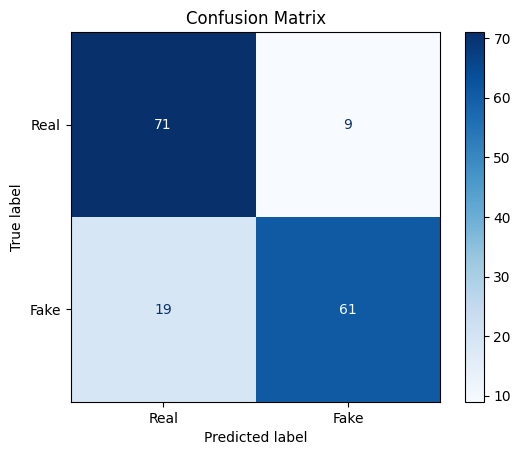

In [ ]:
# Define validation_steps, e.g., based on the dataset size
validation_steps = 20  # Adjust as needed, or calculate dynamically

# Generating predictions for validation videos
y_true, y_pred = [], []
for i in range(validation_steps):
    x_val, y_val = next(validation_generator)
    predictions = model.predict(x_val)
    y_true.extend(y_val)
    y_pred.extend([1 if p > 0.5 else 0 for p in predictions])

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 595s 6s/step - accuracy: 0.5257 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 587s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 578s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 613s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 580s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 581s 6s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
10

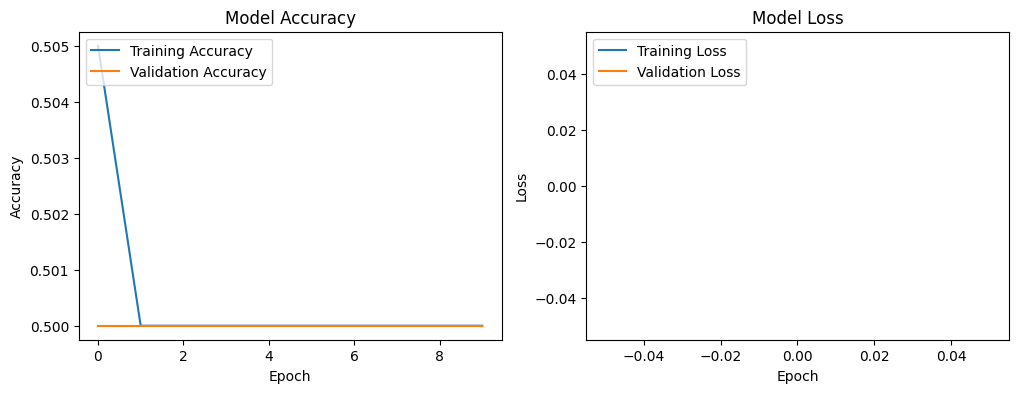

In [ ]:
from tensorflow.keras.optimizers import Adam  # Or any optimizer you're using

# Recreate optimizer
optimizer = Adam()  # Replace with your optimizer and its parameters

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

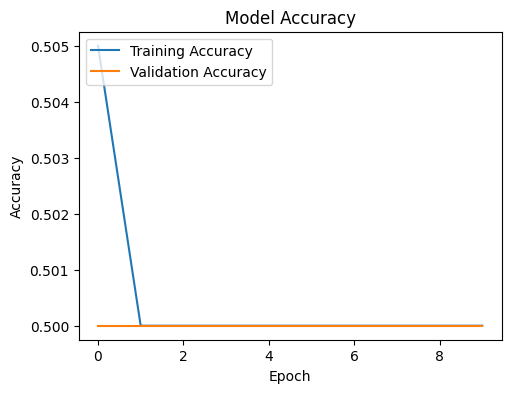

In [ ]:
# Plot training & validation accuracy and loss values as before
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

In [ ]:
x_sample, y_sample = next(train_generator)
print(x_sample.shape, y_sample.shape)

(8, 20, 64, 64, 3) (8,)


In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
# Print the loss values for verification
print("Training Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])

Training Loss: [0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Validation Loss: [0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan]


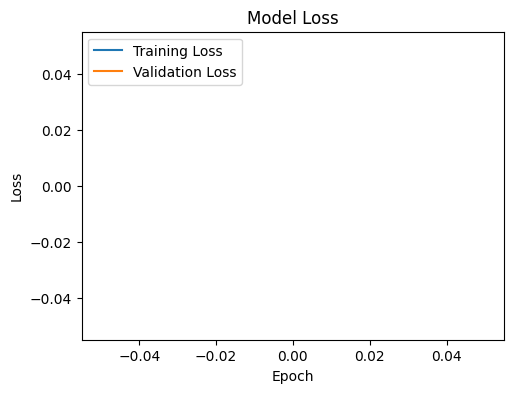

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


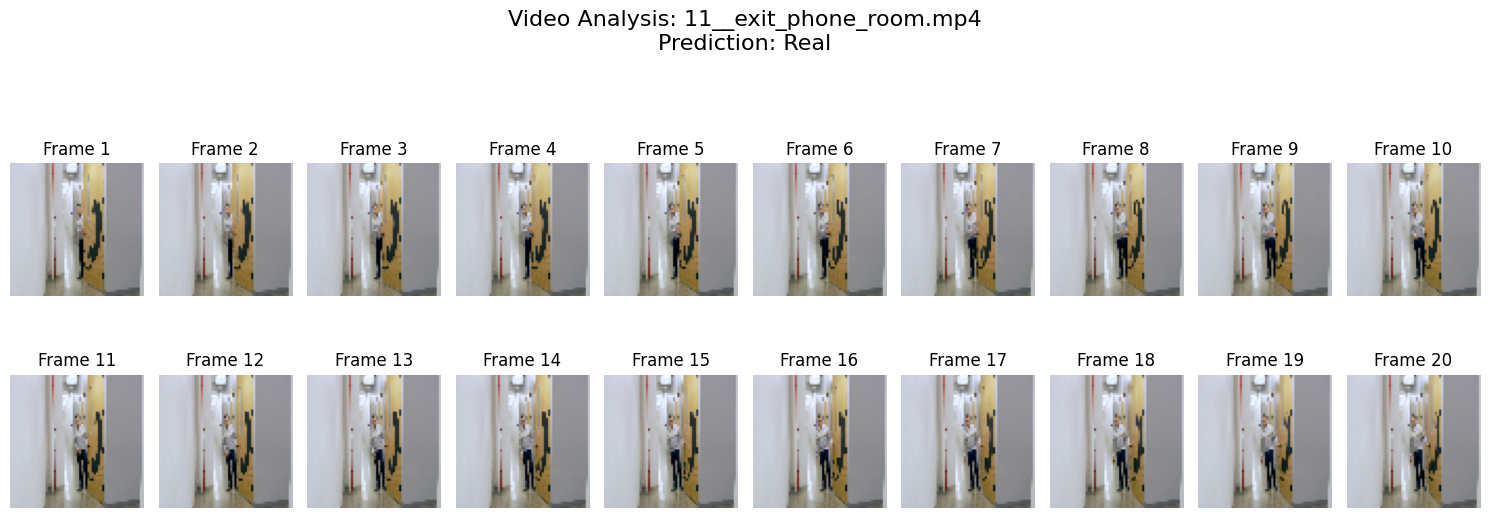

In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def visualize_prediction(video_path, model, sequence_length=20):
    video = cv2.VideoCapture(video_path)
    frames = []
    predictions = []

    # Read and preprocess frames
    while video.isOpened() and len(frames) < sequence_length:
        ret, frame = video.read()
        if not ret:
            break
        frame_resized = cv2.resize(frame, (64, 64))
        frame_array = img_to_array(frame_resized) / 255.0  # Normalize
        frames.append(frame_resized)  # Original frame for display
        predictions.append(frame_array)  # For model prediction

    video.release()

    # If a complete sequence, predict and display frames
    if len(predictions) == sequence_length:
        predictions = np.expand_dims(np.array(predictions), axis=0)  # Add batch dimension
        prediction = model.predict(predictions)
        label = "Fake" if prediction[0] > 0.5 else "Real"

        # Set up the figure for visualization
        plt.figure(figsize=(15, 6))
        plt.suptitle(f"Video Analysis: {video_path.split('/')[-1]}\nPrediction: {label}", fontsize=16)

        # Display each frame with prediction label
        for i, frame in enumerate(frames):
            plt.subplot(2, sequence_length // 2, i + 1)  # Arrange in two rows for better layout
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
            plt.title(f"Frame {i + 1}", fontsize=12)
            plt.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Adjust top to fit the title
        plt.show()
    else:
        print("Video too short or incomplete sequence")

# Example usage
visualize_prediction("/content/drive/MyDrive/SEM-5/FOGAI/ProfElective_GenAI/FF++/real/11__exit_phone_room.mp4", model)